In [23]:
from skimage import transform, feature, io
import numpy as np
import matplotlib.pyplot as plt
from omero.gateway import BlitzGateway
import numpy as np
from lavlab.omero.tiles import create_tile_list_from_image, get_tiles, create_tile_list_2d
from lavlab.python_util import create_array
from lavlab.imsuite import imresize
import lavlab
from scipy.ndimage import gaussian_filter
from skimage import filters, measure, color, morphology
from skimage.color import rgb2hsv
from tqdm import tqdm
import skimage.measure
#
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
import skimage as ski

from skimage.measure import block_reduce
from skimage.morphology import closing, square
from skimage.measure import label
import tqdm
import lavlab
from lavlab.omero.images import mask_omero_tissue_loosely
lavlab.ctx.resources.io_max_threads = 2

import omero.gateway
import numpy as np
import threading
from typing import Generator, Optional
import lavlab
from skimage.feature import blob_dog
import get_rgb_tiles

In [36]:
creds = ("bchao","100Freestyle!")

conn = BlitzGateway(creds[0], creds[1], host="wss://wsi.lavlab.mcw.edu/omero-wss", port=443, secure=True)
conn.connect()
conn.c.enableKeepAlive(60000000)

image_id = 3719

image = conn.getObject("Image", image_id)
if image is None:
    print(f"Image with ID {image_id} not found.")
    conn.close()
    exit()

tile_list = create_tile_list_from_image(image, rgb=True)

# Get image dimensions from metadata
image_width = image.getSizeX()
image_height = image.getSizeY()

# Get downsampled image dimensions
downsampled_width = image_width // 10
downsampled_height = image_height // 10

ki67_down10_image = np.zeros((downsampled_height, downsampled_width, 3), dtype=np.uint8)

block_size = (10,10)

for tile, coord in tqdm.tqdm(get_rgb_tiles.get_rgb_tiles(image, tile_list)):
    z, c, t, (x, y, width, height) = coord
    
    # Compute tile position in the downsampled image
    position_x, position_y = x // 1024, y // 1024
    
    # Get original tile shape
    tile_h, tile_w, _ = tile.shape
    
    # Calculate padding sizes to make dimensions multiples of 10
    pad_h = (10 - (tile_h % 10)) % 10
    pad_w = (10 - (tile_w % 10)) % 10

    # Pad the tile to the nearest multiple of 10
    tile_padded = np.pad(tile, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Downsample the padded tile
    downsampled_tile = np.zeros((tile_padded.shape[0] // 10, tile_padded.shape[1] // 10, 3), dtype=np.uint8)
    for i in range(3):
        downsampled_tile[:, :, i] = skimage.measure.block_reduce(tile_padded[:, :, i], block_size=(10, 10), func=np.mean)

    # Insert downsampled tile into the full downsampled image
    start_x = position_x * downsampled_tile.shape[1]
    start_y = position_y * downsampled_tile.shape[0]

    # Ensure placement does not exceed image bounds
    end_x = min(start_x + downsampled_tile.shape[1], ki67_down10_image.shape[1])
    end_y = min(start_y + downsampled_tile.shape[0], ki67_down10_image.shape[0])

    ki67_down10_image[start_y:end_y, start_x:end_x, :] = downsampled_tile[: end_y - start_y, : end_x - start_x, :]




47000it [31:59, 24.48it/s]


In [39]:
ki67_down10_image = full_downsampled_image

In [47]:
creds = ("bchao","100Freestyle!")

conn = BlitzGateway(creds[0], creds[1], host="wss://wsi.lavlab.mcw.edu/omero-wss", port=443, secure=True)
conn.connect()
conn.c.enableKeepAlive(6000000000)

image_id = 3720

image = conn.getObject("Image", image_id)
if image is None:
    print(f"Image with ID {image_id} not found.")
    conn.close()
    exit()

tile_list = create_tile_list_from_image(image, rgb=True)

# Get image dimensions from metadata
image_width = image.getSizeX()
image_height = image.getSizeY()

# Get downsampled image dimensions
downsampled_width = image_width // 10
downsampled_height = image_height // 10

sox_down10_image = np.zeros((downsampled_height, downsampled_width, 3), dtype=np.uint8)

block_size = (10,10)

for tile, coord in tqdm.tqdm(get_rgb_tiles.get_rgb_tiles(image, tile_list)):
    z, c, t, (x, y, width, height) = coord
    
    # Compute tile position in the downsampled image
    position_x, position_y = x // 1024, y // 1024
    
    # Get original tile shape
    tile_h, tile_w, _ = tile.shape
    
    # Calculate padding sizes to make dimensions multiples of 10
    pad_h = (10 - (tile_h % 10)) % 10
    pad_w = (10 - (tile_w % 10)) % 10

    # Pad the tile to the nearest multiple of 10
    tile_padded = np.pad(tile, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Downsample the padded tile
    downsampled_tile = np.zeros((tile_padded.shape[0] // 10, tile_padded.shape[1] // 10, 3), dtype=np.uint8)
    for i in range(3):
        downsampled_tile[:, :, i] = skimage.measure.block_reduce(tile_padded[:, :, i], block_size=(10, 10), func=np.mean)

    # Insert downsampled tile into the full downsampled image
    start_x = position_x * downsampled_tile.shape[1]
    start_y = position_y * downsampled_tile.shape[0]
    
    # Ensure placement does not exceed image bounds
    end_x = min(start_x + downsampled_tile.shape[1], sox_down10_image.shape[1])
    end_y = min(start_y + downsampled_tile.shape[0], sox_down10_image.shape[0])
    
    # Check if the computed slice is valid before inserting
    if start_x < end_x and start_y < end_y:
        sox_down10_image[start_y:end_y, start_x:end_x, :] = downsampled_tile[: end_y - start_y, : end_x - start_x, :]

44004it [30:02, 24.41it/s]


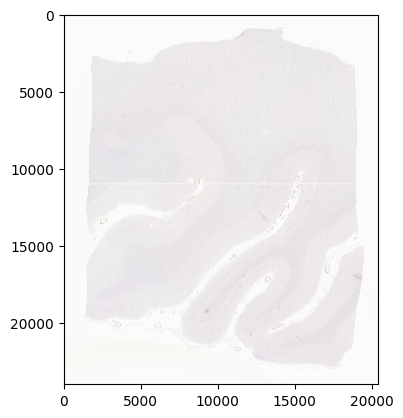

In [44]:
plt.imshow(ki67_down10_image)

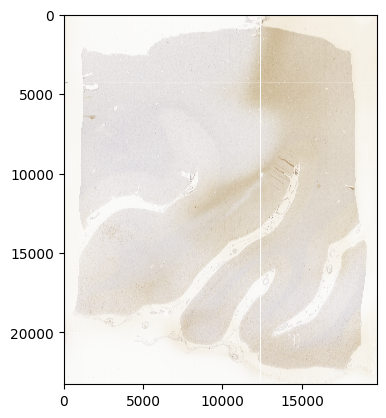

In [48]:
plt.imshow(sox_down10_image)

In [5]:
data = np.load('/Volumes/Siren/Brain_data/1.PatientDirectory/225/Histology/Processed/S19_Large/SOX2/i2m.npz')

In [6]:
import scipy.io

# Load the .mat file
data2 = scipy.io.loadmat('/Volumes/Siren/Brain_data/1.PatientDirectory/225/Histology/Processed/S19_Large/SOX2/i2m_hires.mat')

# Check the contents of the loaded file
print(data2.keys())  # Lists all the variables in the .mat file


dict_keys(['__header__', '__version__', '__globals__', 'out'])


In [7]:
array2 = data2['out']['cell_den'][0][0]
array2.shape

(556, 508, 3)

In [8]:

plt.imshow(array2[:,:,2], cmap='jet')

NameError: name 'plt' is not defined

In [9]:
print(np.sum(array2[:,:,2]))

11911.533065435373


In [10]:
array = data['ratio']
array.shape

(249, 272)

In [11]:
print(np.sum(array))

1433.122229143917


In [12]:
flipped_array = np.flipud(array)
rotated_array = np.rot90(flipped_array, k=-1)  # Rotate 90 degrees clockwise


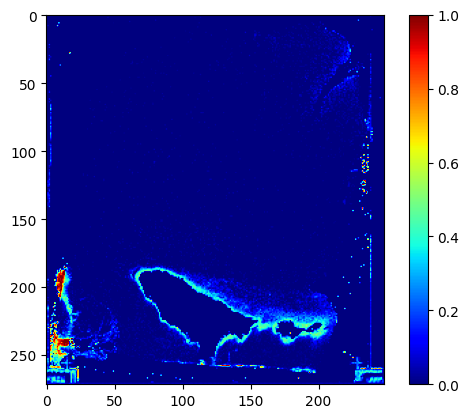

In [13]:
import matplotlib.pyplot as plt

plt.imshow(rotated_array, cmap='jet')  # Display in grayscale
plt.colorbar()  # Add a color bar (optional)
plt.show()

In [17]:
array2[:,:,2].shape

(556, 508)

In [18]:
rotated_array.shape

(272, 249)

In [14]:
from skimage import transform, feature, io
import numpy as np

img1 = rotated_array
img2 = array2[:,:,2]

keypoints1, descriptors1 = feature.ORB().detect_and_extract(img1)
keypoints2, descriptors2 = feature.ORB().detect_and_extract(img2)

matches = feature.match_descriptors(descriptors1, descriptors2, cross_check=True)

src = keypoints1[matches[:, 0]][:, ::-1]
dst = keypoints2[matches[:, 1]][:, ::-1]

tform = transform.estimate_transform('similarity', src, dst)
aligned_img2 = transform.warp(img2, tform.inverse, output_shape=img1.shape)

TypeError: cannot unpack non-iterable NoneType object

In [19]:
from skimage import transform, feature, io, img_as_ubyte
import numpy as np

# Convert images to uint8 if they are not already
img1 = img_as_ubyte(rotated_array)   # Ensure the correct format
img2 = img_as_ubyte(array2[:, :, 2]) # Extract the channel and convert

# Initialize ORB detector
orb = feature.ORB()

# Detect and extract features
orb.detect_and_extract(img1)
keypoints1, descriptors1 = orb.keypoints, orb.descriptors

orb.detect_and_extract(img2)
keypoints2, descriptors2 = orb.keypoints, orb.descriptors

# Match descriptors
matches = feature.match_descriptors(descriptors1, descriptors2, cross_check=True)

# Ensure there are enough matches
if len(matches) < 4:
    raise ValueError("Not enough matches found for transformation!")

# Extract matching keypoints
src = keypoints1[matches[:, 0]][:, ::-1]  # (y, x) to (x, y)
dst = keypoints2[matches[:, 1]][:, ::-1]

# Estimate transformation (similarity: rigid + scaling)
tform = transform.estimate_transform('similarity', src, dst)

# Warp image
aligned_img2 = transform.warp(img2, tform.inverse, output_shape=img1.shape)


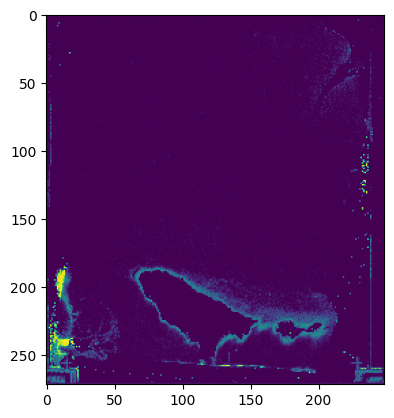

In [20]:
plt.imshow(img1)